In [1]:
try:
  from google import colab
  colab.drive.mount("/content/gdrive")
  %pip install -qU neptune
  DRIVE_ROOT = "/content/gdrive/My Drive/"
except ModuleNotFoundError:
  DRIVE_ROOT = "H:\\我的云端硬盘\\"

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 114.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.3 MB/s eta 0:00:00


In [2]:
import os

PROJECT_NAME = "cnn-hllpi-lwc-regression"
PROJECT_ROOT = os.path.join(DRIVE_ROOT, "Repositories", PROJECT_NAME)
print(f"Project root at:\n  {PROJECT_ROOT}")

DATA_FOLDER = os.path.join(PROJECT_ROOT, "data")
assert os.path.exists(DATA_FOLDER), "Data folder not found!"
EXPERIMENT_FOLDER = os.path.join(PROJECT_ROOT, "experiments")
os.makedirs(EXPERIMENT_FOLDER, exist_ok=True)

Project root at:
  /content/gdrive/My Drive/Repositories/cnn-hllpi-lwc-regression


In [3]:
import sys
sys.path.append(PROJECT_ROOT)

import utils
utils.ensure_reproduction(42)

Random seed set to 42 and cudnn deterministic mode set to True.


In [4]:
import torch
from torch import nn
from torch.utils import data
import train
import evaluate
import models
from torchvision import transforms
from typing import Type, Tuple
import neptune
from neptune import types

In [5]:
def run_experiment(
    model_name: str,
    model_cls: Type[nn.Module],
    experiment_name: str,
    stage: str,
    config_filename: str,
    data_loaders: Tuple[data.DataLoader, ...],
    logger: neptune.Run,
    max_epochs: int,
    validation_freq: int,
  ) -> None:
  utils.register_model(model_name, model_cls)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  train_dataloader, val_dataloader, test_dataloader = data_loaders

  train_result = train.train_model(
      os.path.join(EXPERIMENT_FOLDER, experiment_name),
      config_filename,
      train_dataloader,
      val_dataloader,
      device,
      logger,
      max_epochs=max_epochs,
      validation_freq=validation_freq,
  )
  print(f"Best val loss: {train_result['best_loss']}.")

  test_result = evaluate.test_model(
    stage,
    os.path.join(EXPERIMENT_FOLDER, experiment_name),
    config_filename,
    train_result["best_model"],
    test_dataloader,
    device,
    logger,
  )
  print(f"Test loss: {test_result['loss']}, "
        f"test accuracy: {test_result['accuracy']}.")

In [6]:
MODEL_NAMES = ["alexnet", "densenet", "custom_vgg"]
MODEL_CLASSES = [models.AlexNet, models.DenseNet, models.CustomVggNet]
EXPERIMENT_GROUP = "alexnet"
MAX_EPOCHS = 180
VALIDATION_FREQ = 6

In [7]:
dataloaders = models.vision_dataloaders_from_directory(
  DATA_FOLDER,
  transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180, fill=(127, 0, 0)),
  ]),
  abandonment_ratio=None,
)

Normalize arguments: (tensor([0.2426, 0.3961, 0.3093]), tensor([0.5319, 0.2636, 0.1422])).
Length of train dataset: 270.
Length of validation dataset: 68.
Length of test dataset: 75.


<ipython-input-8-2e6b881a0374>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  neptune_logger = neptune.init_run(


https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-2
Using device: cuda


/content/gdrive/My Drive/Repositories/cnn-hllpi-lwc-regression/utils/items.py:40: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  logger["configurations"] = config
100%|██████████| 180/180 [15:21<00:00,  5.12s/it]


Best model archive: alexnet_step78_loss0.0261.pth.
Best val loss: 0.026068453676998615.
Test loss: 0.028199334512464702, test accuracy: 0.29333333333333333.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-2/metadata


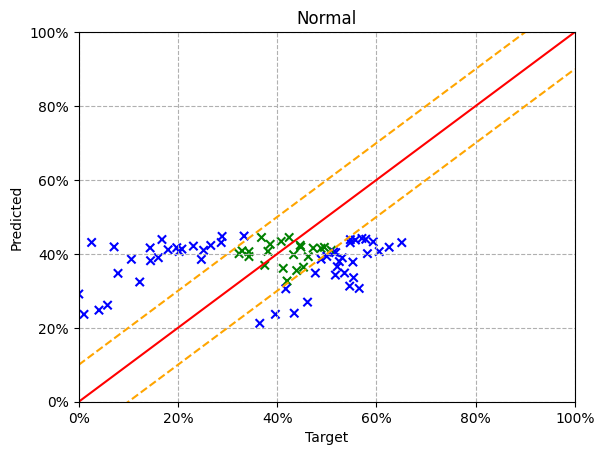

In [8]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-2",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "alexnet",
  models.AlexNet,
  "alexnet",
  "Normal",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-3
Using device: cuda


100%|██████████| 180/180 [20:00<00:00,  6.67s/it]


Best model archive: densenet_step108_loss0.0261.pth.
Best val loss: 0.026084863181625093.
Test loss: 0.02771980158286169, test accuracy: 0.41333333333333333.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-3/metadata


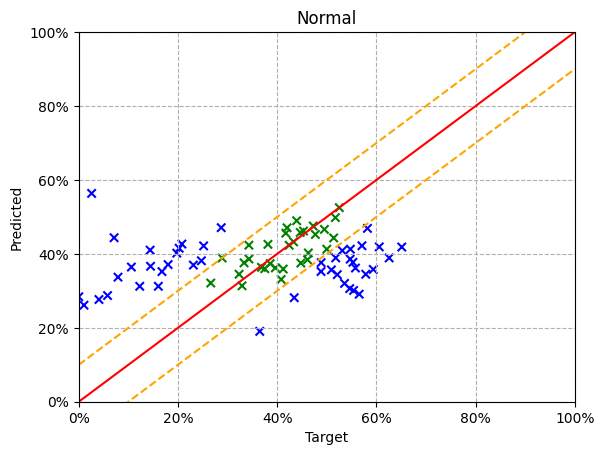

In [9]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-3",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "densenet",
  models.DenseNet,
  "densenet",
  "Normal",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-4
Using device: cuda


100%|██████████| 180/180 [15:05<00:00,  5.03s/it]


Best model archive: customvggnet_step156_loss0.0281.pth.
Best val loss: 0.028148420687232698.
Test loss: 0.027480330201797187, test accuracy: 0.28.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-4/metadata


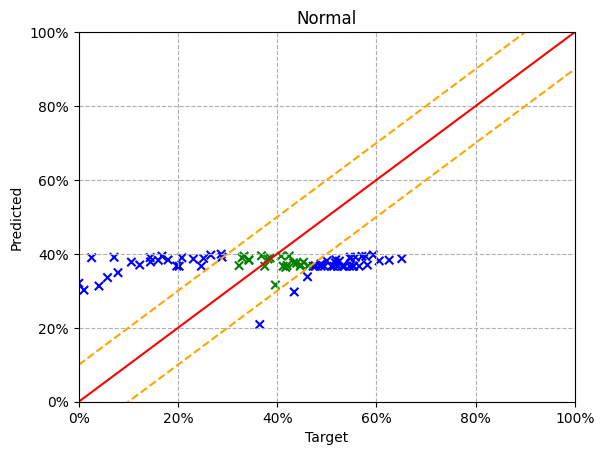

In [10]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-4",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "custom_vgg",
  models.CustomVggNet,
  "custom_vgg",
  "Normal",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

___

In [11]:
dataloaders = models.vision_dataloaders_from_directory(
  DATA_FOLDER,
  transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180, fill=(127, 0, 0)),
  ]),
  abandonment_ratio=0.3,
)

Normalize arguments: (tensor([0.2426, 0.3982, 0.3087]), tensor([0.5330, 0.2666, 0.1423])).
Length of train dataset: 189.
Length of validation dataset: 48.
Length of test dataset: 75.


https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-5
Using device: cuda


100%|██████████| 180/180 [10:21<00:00,  3.45s/it]


Best model archive: alexnet_step24_loss0.0357.pth.
Best val loss: 0.03572736084461212.
Test loss: 0.025463814614340663, test accuracy: 0.26666666666666666.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-5/metadata


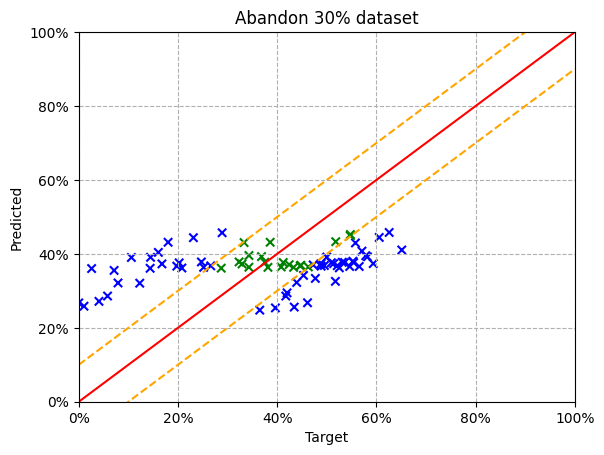

In [12]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-5",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "alexnet",
  models.AlexNet,
  "alexnet",
  "Abandon 30% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-6
Using device: cuda


100%|██████████| 180/180 [13:38<00:00,  4.55s/it]


Best model archive: densenet_step24_loss0.0372.pth.
Best val loss: 0.03716554269194603.
Test loss: 0.028254531673155725, test accuracy: 0.2.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-6/metadata


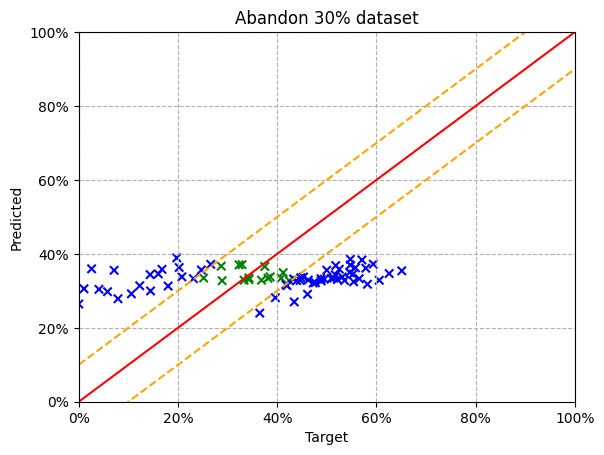

In [13]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-6",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "densenet",
  models.DenseNet,
  "densenet",
  "Abandon 30% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-7
Using device: cuda


100%|██████████| 180/180 [10:19<00:00,  3.44s/it]


Best model archive: customvggnet_step6_loss0.0371.pth.
Best val loss: 0.037117210775613786.
Test loss: 0.028416700108209625, test accuracy: 0.3333333333333333.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-7/metadata


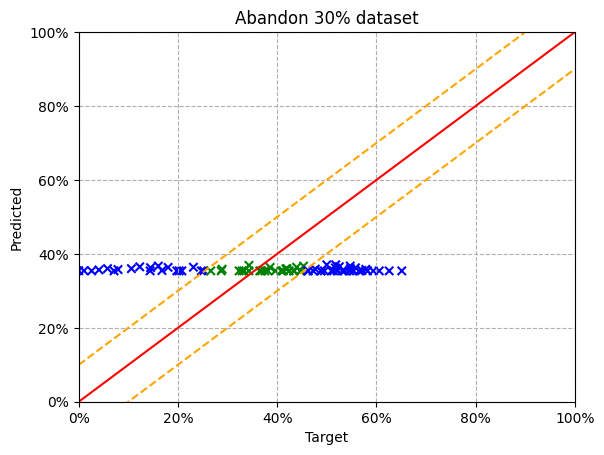

In [14]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-7",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "custom_vgg",
  models.CustomVggNet,
  "custom_vgg",
  "Abandon 30% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

---

In [15]:
dataloaders = models.vision_dataloaders_from_directory(
  DATA_FOLDER,
  transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180, fill=(127, 0, 0)),
  ]),
  abandonment_ratio=0.6,
)

Normalize arguments: (tensor([0.2475, 0.3895, 0.3126]), tensor([0.5325, 0.2571, 0.1413])).
Length of train dataset: 108.
Length of validation dataset: 28.
Length of test dataset: 75.


https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-8
Using device: cuda


100%|██████████| 180/180 [05:57<00:00,  1.99s/it]


Best model archive: alexnet_step30_loss0.0289.pth.
Best val loss: 0.028879819437861443.
Test loss: 0.026235031080432236, test accuracy: 0.24.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-8/metadata


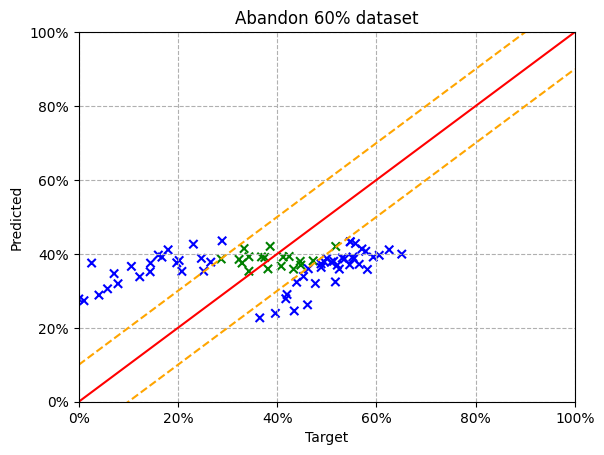

In [16]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-8",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "alexnet",
  models.AlexNet,
  "alexnet",
  "Abandon 60% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-9
Using device: cuda


100%|██████████| 180/180 [07:45<00:00,  2.58s/it]


Best model archive: densenet_step162_loss0.0220.pth.
Best val loss: 0.022034747215608757.
Test loss: 0.020574176160153, test accuracy: 0.44.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-9/metadata


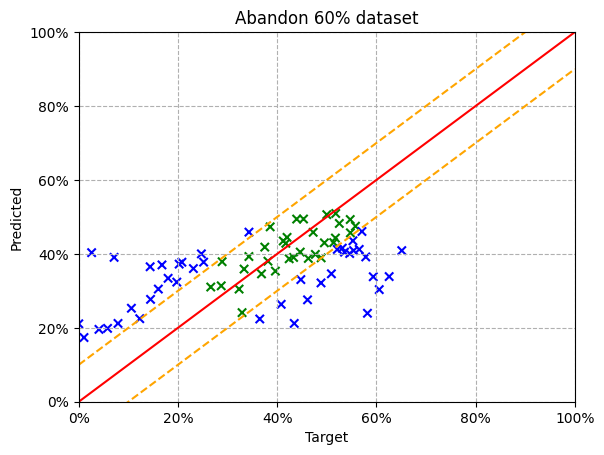

In [17]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-9",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "densenet",
  models.DenseNet,
  "densenet",
  "Abandon 60% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-10
Using device: cuda


100%|██████████| 180/180 [05:55<00:00,  1.97s/it]


Best model archive: customvggnet_step108_loss0.0311.pth.
Best val loss: 0.031074992070595425.
Test loss: 0.027230966079514474, test accuracy: 0.28.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-10/metadata


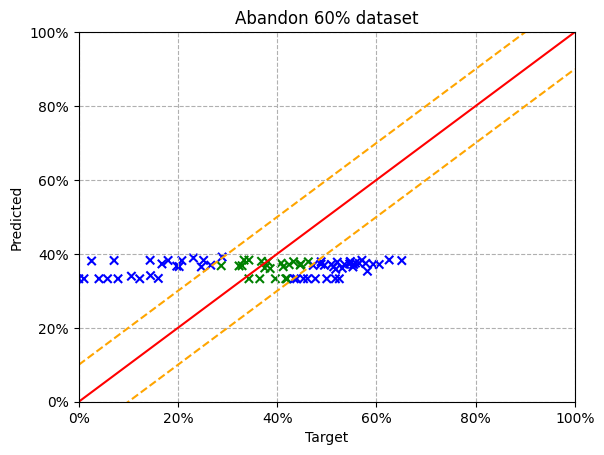

In [18]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-10",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "custom_vgg",
  models.CustomVggNet,
  "custom_vgg",
  "Abandon 60% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

---

In [7]:
dataloaders = models.vision_dataloaders_from_directory(
  DATA_FOLDER,
  transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180, fill=(127, 0, 0)),
  ]),
  abandonment_ratio=0.15,
)

Normalize arguments: (tensor([0.2433, 0.3914, 0.3093]), tensor([0.5321, 0.2576, 0.1407])).
Length of train dataset: 230.
Length of validation dataset: 58.
Length of test dataset: 75.


<ipython-input-8-070205442d7e>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  neptune_logger = neptune.init_run(


https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-11
Using device: cuda


/content/gdrive/My Drive/Repositories/cnn-hllpi-lwc-regression/utils/items.py:40: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  logger["configurations"] = config
100%|██████████| 180/180 [14:19<00:00,  4.77s/it]


Best model archive: alexnet_step30_loss0.0265.pth.
Best val loss: 0.026535412451873224.
Test loss: 0.023885634960606694, test accuracy: 0.30666666666666664.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-11/metadata


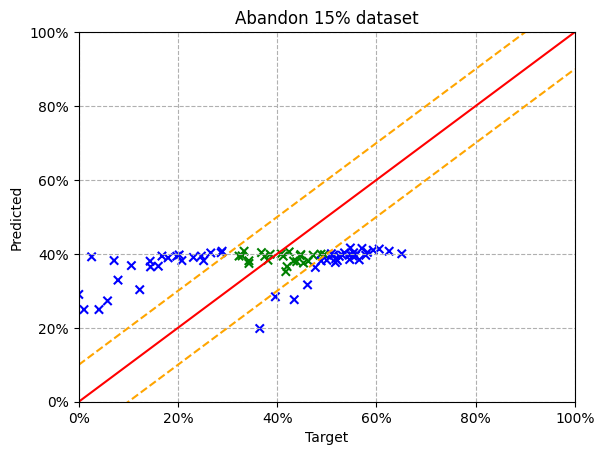

In [8]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-11",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "alexnet",
  models.AlexNet,
  "alexnet",
  "Abandon 15% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-12
Using device: cuda


100%|██████████| 180/180 [18:14<00:00,  6.08s/it]


Best model archive: densenet_step18_loss0.0397.pth.
Best val loss: 0.03969641029834747.
Test loss: 0.031778364442288876, test accuracy: 0.29333333333333333.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-12/metadata


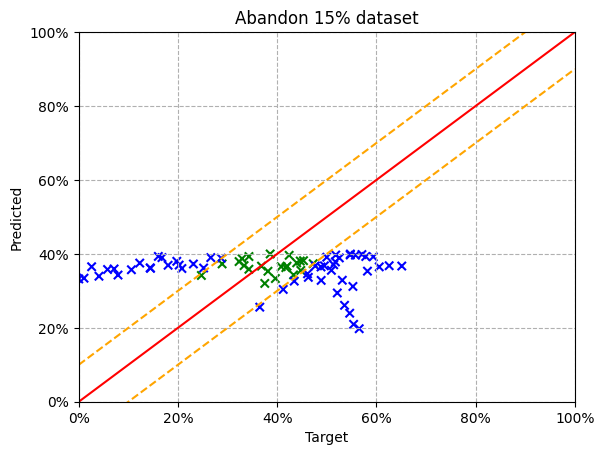

In [9]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-12",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "densenet",
  models.DenseNet,
  "densenet",
  "Abandon 15% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-13
Using device: cuda


100%|██████████| 180/180 [14:07<00:00,  4.71s/it]


Best model archive: customvggnet_step0_loss0.1866.pth.
Best val loss: 0.18658589075009027.
Test loss: 0.16939770989120007, test accuracy: 0.09333333333333334.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-13/metadata


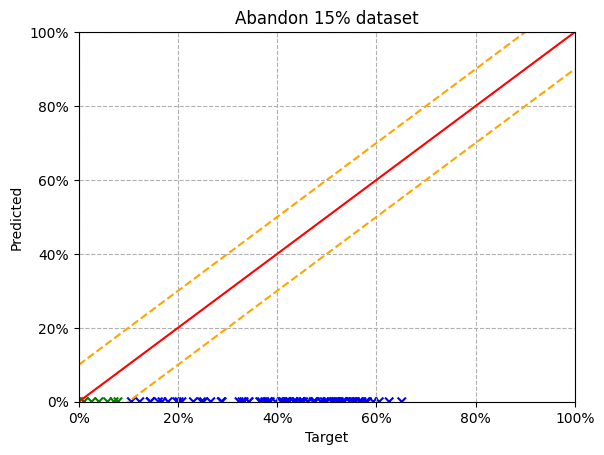

In [10]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-13",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "custom_vgg",
  models.CustomVggNet,
  "custom_vgg",
  "Abandon 15% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

---

In [11]:
dataloaders = models.vision_dataloaders_from_directory(
  DATA_FOLDER,
  transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180, fill=(127, 0, 0)),
  ]),
  abandonment_ratio=0.45,
)

Normalize arguments: (tensor([0.2410, 0.3943, 0.3048]), tensor([0.5348, 0.2605, 0.1383])).
Length of train dataset: 148.
Length of validation dataset: 38.
Length of test dataset: 75.


https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-14
Using device: cuda


100%|██████████| 180/180 [08:56<00:00,  2.98s/it]


Best model archive: alexnet_step156_loss0.0345.pth.
Best val loss: 0.03449518699198961.
Test loss: 0.02853811637032777, test accuracy: 0.28.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-14/metadata


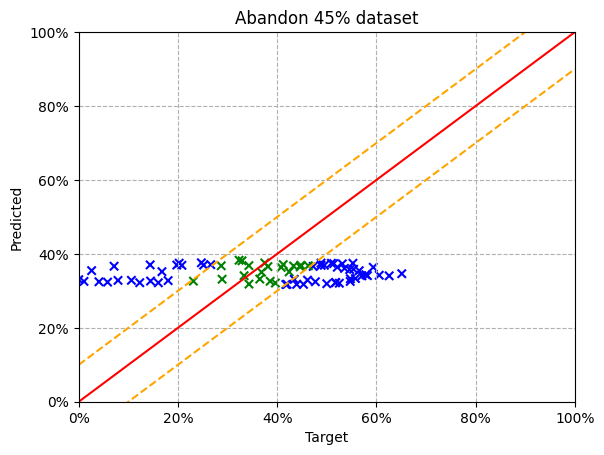

In [12]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-14",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "alexnet",
  models.AlexNet,
  "alexnet",
  "Abandon 45% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-15
Using device: cuda


100%|██████████| 180/180 [11:04<00:00,  3.69s/it]


Best model archive: densenet_step114_loss0.0351.pth.
Best val loss: 0.035125465830788016.
Test loss: 0.023201498261187226, test accuracy: 0.3333333333333333.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-15/metadata


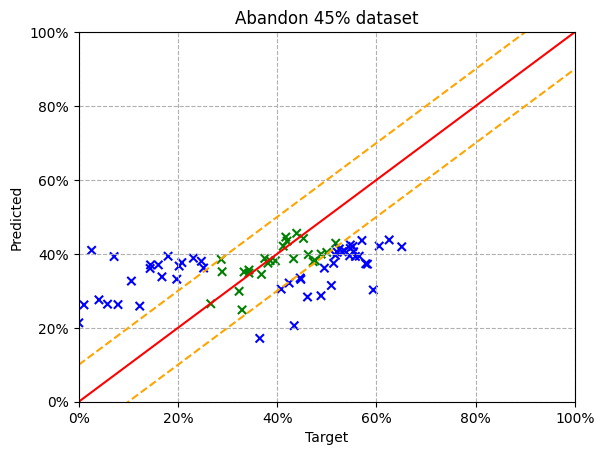

In [13]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-15",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "densenet",
  models.DenseNet,
  "densenet",
  "Abandon 45% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-16
Using device: cuda


100%|██████████| 180/180 [08:43<00:00,  2.91s/it]


Best model archive: customvggnet_step96_loss0.0290.pth.
Best val loss: 0.029041036032140255.
Test loss: 0.028125740820541978, test accuracy: 0.24.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tioplato-epstein/cnn-hllpi-lwc-regression/e/CNNHLLPI-16/metadata


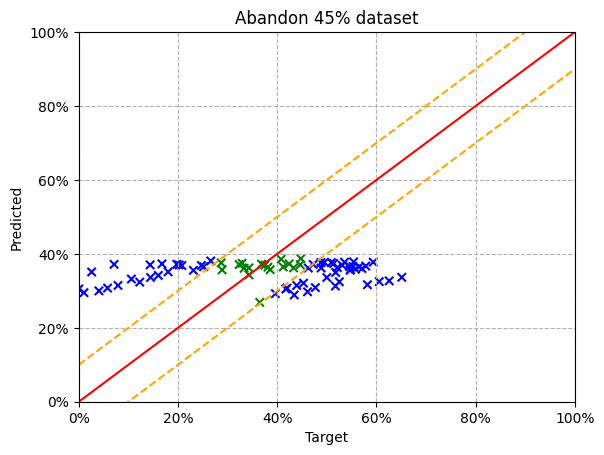

In [14]:
neptune_logger = neptune.init_run(
    project=f"tioplato-epstein/{PROJECT_NAME}",
    with_id="CNNHLLPI-16",
    api_token="",
    git_ref=types.GitRef(f"{PROJECT_ROOT}")
)
run_experiment(
  "custom_vgg",
  models.CustomVggNet,
  "custom_vgg",
  "Abandon 45% dataset",
  "config.json",
  dataloaders,
  neptune_logger,
  max_epochs=MAX_EPOCHS,
  validation_freq=VALIDATION_FREQ,
)
neptune_logger.wait()
neptune_logger.stop()

In [15]:
if neptune_logger._with_id is not None:
  try:
    del neptune_logger["metrics"]
    del neptune_logger["checkpoints"]
    del neptune_logger["configurations"]
    del neptune_logger["plots"]
  except BaseException:
    pass  # Just to make sure that the keys are not there